<a href="https://colab.research.google.com/github/ykenkou001/Pytorch-ni-yoru-hatten-deeplearning/blob/main/2_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Pytorchによる発展ディープラーニング /pytorch_advanced/2_objectdetection

/content/drive/MyDrive/Colab Notebooks/Pytorchによる発展ディープラーニング /pytorch_advanced/2_objectdetection


# 2.2 Datasetの実装、2.3 DataLoaderの実装

# 2.2 学習目標  


1.   物体検出で使用するDatasetクラスを作成できるようになる
2.   SSDの学習時のデータオーギュメンテーションで、何をしているかを理解する



In [ ]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [ ]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 画像データ、アノテーションデータへのファイルパスのリストを作成する

In [ ]:
# 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する
def make_datapath_list(rootpath):
  """
  データへのパスを格納したリストを作成する

  Parametars:
  ---------------
  rootpath : str
    データへのパス

  Returns
  -----------
  ret : train_img_list, train_anno_list, val_img_list, val_anno_list
    データへのパスを格納したリスト

  """

  # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
  imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
  annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

  # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
  train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
  val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')


  # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
  train_img_list = list()
  train_anno_list = list()
  
  for line in open(train_id_names):
    file_id = line.strip() # 空白スペースと改行を除去
    # print(file_id)
    img_path = (imgpath_template % file_id) # 画像のパス
    anno_path = (annopath_template % file_id) # アノテーションのパス
    train_img_list.append(img_path) # リストに追加
    train_anno_list.append(anno_path) # リストに追加

  val_img_list = list()
  val_anno_list = list()

  for line in open(val_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id)
    anno_path = (annopath_template % file_id)
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)

  return train_img_list, train_anno_list, val_img_list, val_anno_list

In [ ]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = \
make_datapath_list(rootpath=rootpath)

# 動作確認
print(len(train_img_list))
print(len(val_img_list))
print(train_img_list[0])

5717
5823
./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


# xml形式のアノテーションデータをリストに変換する

In [ ]:
# 「XML形式のアノテーション」をリスト形式に変換するクラス

class Anno_xml2list(object):
  """
  １枚の画像に対する「XML 形式のアノテーションデータ」を画像サイズで規格化してから
  リスト形式に変換する

  Args:
  --------
  classes : list
    VOCのクラス名を格納したリスト
  """

  def __init__(self, classes):
    self.classes = classes

  def __call__(self, xml_path, width, height):
    """
    １枚の画像に対する「xml形式のアノテーションデータ」を画像サイズで規格化してから
    リスト形式に変換する

    Parameters
    ---------------
    xml_path : str
      path to xml file
    width : int 
      images width
    height : int
      target images height

    Returns
    ---------
    ret : [[xmin, ymin, xmax, ymax, label_ind], ....]
      物体のアノテーションデータを格納したリスト。画像内に存在する物体数分だけ
      要素を持つ
    """

    # 画像内の全ての物体のアノテーションをこのリストに格納する
    ret = []

    # xmlファイルを読み込む
    xml = ET.parse(xml_path).getroot()

    # 画像内にある物体（object)の数だけループする
    for obj in xml.iter('object'):
      print(obj)
      # アノテーションで検知がdifficultに設定されているものは除外
      difficult = int(obj.find('difficult').text)
      if difficult == 1:
        continue

      # １つの物体に対するアノテーションを格納するリスト
      bndbox = []

      name = obj.find('name').text.lower().strip() # 物体名
      bbox = obj.find('bndbox') # bboxの情報

      # アノテーションデータのxmin, ymin, xmax, ymaxを取得し、0~1に規格化
      pts = ['xmin', 'ymin', 'xmax', 'ymax']

      for pt in (pts):
        # VOCは原点が（１、１）なので１を引き算して、（０、０）に
        cur_pixel = int(bbox.find(pt).text) - 1

        #幅、高さで規格化、pixel単位に直す？？？
        if pt == 'xmin' or pt == 'xmax': # x奉公の時幅で割り算
          cur_pixel /= width
        else: # y奉公の時は高さで割り算
          cur_pixel /= height
        
        bndbox.append(cur_pixel)

      #　アノテーションのクラス名のindexを取得して追加
      label_idx = self.classes.index(name)
      bndbox.append(label_idx)

      # retに[xmin, ymin, xmax, ymax, label_idx]をたす
      ret += [bndbox]

    return np.array(ret) # [[xmin, ymin, xmax, ymax, label_ind], ....]

In [ ]:
# 動作確認
voc_classes = voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
transform_anno = Anno_xml2list(voc_classes)

# Read images with using Opencv
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path) # [h][w][rgb]
height, width, channels = img.shape # get image size

# アノテーションリストを表示
transform_anno(val_anno_list[ind], width, height)

<Element 'object' at 0x7fc150156d18>
<Element 'object' at 0x7fc150156688>


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

# 画像とアノテーションの前処理を行うクラスDataTransformerを作成


In [ ]:
# フォルダ「utils」にあるdata_augumentation.pyからimport
# Class for preprocessing input Images

from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, \
PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, \
Resize, SubtractMeans

class DataTransfrom():
  """
  画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
  画像のサイズを３００×300にする
  学習時はDataAugumentationする

  Args:
  -------
  input_size : int
    リサイズ先の画像の大きさ
  color_mean : (b, g, r)
    各色チャネルの平均値
  """

  def __init__(self, input_size, color_mean):
    self.data_transform = {
        'train': Compose([
            ConvertFromInts(), # Convert int to float32
            ToAbsoluteCoords(), # Return standardization of anno data
            PhotometricDistort(), # 画像の色調などをランダムに変か
            Expand(color_mean), # Expand cambus of image
            RandomSampleCrop(), # 画像内の部分をランダムに抜き出す
            RandomMirror(),  
        ]),
        'val' : Compose([
            ConvertFromInts(), # convert int to float
            Resize(input_size), # transform image size to input_size * input_size
            SubtractMeans(color_mean) # bgrの色の平均値を引き算
        ])
    }

  def __call__(self, img, phase, boxes, labels):
    """
    Prameters
    -------------
    phase : 'train' or 'val'
      前処理のモードを指定
    """
    return self.data_transform[phase](img, boxes, labels)

<Element 'object' at 0x7fc14ee681d8>
<Element 'object' at 0x7fc14ee68548>


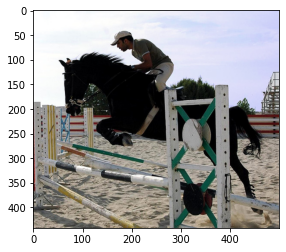

/content/drive/My Drive/Colab Notebooks/Pytorchによる発展ディープラーニング /pytorch_advanced/2_objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


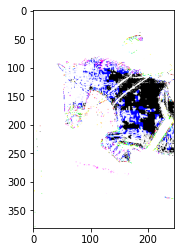

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


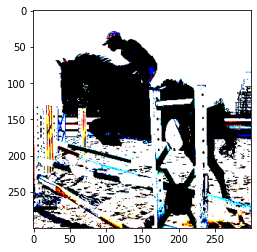

In [ ]:
# 動作の確認

# 1. 画像の読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path) # [h][w][bgr]
height, width, channels = img.shape # get image size

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123) # （bgr)の色の平均値
input_size = 300 # 画像のinputサイズを３００*３００にする
transform = DataTransfrom(input_size, color_mean)

# 5. train画像の表示
phase = 'train'
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. val画像の表示
phase = 'val'
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# Datasetを作成

In [ ]:
# VOC2012のDatasetを作成する

class VOCDataset(data.Dataset):
  """
  VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

  Attributes
  --------------
  img_list : list
    画像のパスを格納したリスト
  anno_list : list
    アノテーションへのパスを格納したリスト
  phase ; 'trian' or 'test'
    学習か訓練かを設定する
  transform : obj
    前処理クラスのインスタンス
  transform_anno : obj
    xmlのアノテーションをリストに変換するインスタンス
  """

  def __init__(self, img_list, anno_list, phase, transform, transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform # 画像の変形
    self.transform_anno = transform_anno # アノテーションデータをxmlからリストへ

  def __len__(self):
    """画像の枚数を返す"""
    return len(self.img_list)

  def __getitem__(self, index):
    """
    前処理をした画像のテンソル形式のデータとアノテーションを取得
    """
    im, gt, h, w = self.pull_item(index)
    return im, gt
  
  def pull_item(self, index):
    '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する
    '''
    # 1. 画像読み込み
    image_file_path = self.img_list[index]
    img = cv2.imread(image_file_path) # [h][w][bgr]
    height, width, channels = img.shape # get image size

    # 2. xml形式のアノテーション情報をリストに
    anno_file_path = self.anno_list[index]
    anno_list = self.transform_anno(anno_file_path, width, height)

    # 3. 前処理を実施
    img, boxes, labels = self.transform(
        img, self.phase, anno_list[:, :4], anno_list[:, 4]
    )
    # 色チャネルの順番がbgrになっているので、RGBに順番変更
    # さらに（h、w, chanel)の順を(channel, h, w)に変換
    img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # BBOXとラベルをセットにしたnp.arrayを作成
    gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

    return img, gt, height, width

In [ ]:
# 動作確認
color_mean = (104, 117, 123) # (bgr)の色の平均値
imput_size = 300 # 画像のinputサイズを300*300にする

train_dataset =  VOCDataset(train_img_list, train_anno_list, phase='train', 
                            transform=DataTransfrom(
                                input_size, color_mean
                            ), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', 
                         transform=DataTransfrom(
                             input_size, color_mean
                         ), transform_anno=Anno_xml2list(voc_classes))

# データの取り出し例
val_dataset.__getitem__(1)

<Element 'object' at 0x7fc144ae9728>
<Element 'object' at 0x7fc144ae9a98>


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoaderを作成

In [ ]:
def od_collate_fn(batch):
  """
  Datasetから取り出すアノテーションデータのサイズが画像ごとに異なる。
  画像内の物体数が２個であれば（２、５）というサイズですが、３個あれば（３、５）など変化する。
  この変化に対応したDataLoaderを作成するために、カスタマイズした、collate_fnを作成する。
  collate_fnは、PyTorchでリストからmini-batchを作成する関数。
  ミニバッチ分の画像が並んでいるリスト変数batchに、ミニバッチ番号を
  指定する次元を先頭に１つ追加して、リストの形を変形する。
  """

  targets = []
  imgs = []
  for sample in batch:
    imgs.append(sample[0]) # sample[0]は画像img
    targets.append(torch.FloatTensor(sample[1])) # sample[1]はアノテーションgt

  # imgsはミニバッチサイズのリストになっている
  # リストの要素はtorch.Size([3, 300, 300])
  # このリストをtorch.Size([batch_num 3, 300, 300])のテンソルに変換
  imgs = torch.stack(imgs, dim=0)

  # targetsはアノテーションデータの正解であるgtのリストです
  # リストのサイズはミニバッチサイズです。
  # リストtargetsの要素は[n, 5]となっている
  # nは画像ごとに異なり、画像内にある物体の数となる
  # 5は[xmin, ymin, xmax, ymax, class_index]です

  return imgs, targets

In [ ]:
# Create DataLoader

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn = od_collate_fn
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn = od_collate_fn
)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"]) # イテレータに変換
images, targets = next(batch_iterator) # 1番目の要素を取り出す
# print(images.size()) # torch.Size([4, 3 300, 300])
# print(len(targets))
# print(targets[1].size()) # ミニバッチのサイズのリスト、各要素は[n, s], nは物体数

<Element 'object' at 0x7fc144a99138>
<Element 'object' at 0x7fc144b15f48>
<Element 'object' at 0x7fc144a99bd8>
<Element 'object' at 0x7fc144a99688>
<Element 'object' at 0x7fc144ab24f8>
<Element 'object' at 0x7fc144ab26d8>
<Element 'object' at 0x7fc144a99c28>
<Element 'object' at 0x7fc144ab2458>
<Element 'object' at 0x7fc144a99188>


In [ ]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


以上
